<a href="https://colab.research.google.com/github/carolina-garay/AnalisisYCuracion_Grupo32/blob/Seba-Ormaechea/Pr%C3%A1ctico2_AyC_Parte1_SGO_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2022*

----

# Trabajo práctico N°2. Análisis y Curación de datos. Entregable - parte 1

El objetivo de este práctico es: Obtener una base de datos capaz de ser utilizada posteriormente para la construcción de un modelo que prediga el valor de venta de una propiedad en la ciudad de Melbourne, Australia. Para ello, se cargan dos conjuntos de datos. El [primero](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) es de la compentencia Kaggle sobre estimación de precios de ventas de propiedades en Melbourne, Australia. El [segundo](https://www.kaggle.com/datasets/tylerx/melbourne-airbnb-open-data) es un conjunto de datos  elaborado a partir de datos de la plataforma Airbnb, que se buscará unir al primer dataset con el objetivo de sumarle información.

In [ ]:
!pip install pandas_profiling==2.8.0
!pip install pandas==1.2.0

In [ ]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_context('talk')

#from decouple import config
from sqlalchemy import create_engine, text
import plotly
plotly.__version__

## Ejercicio 1 SQL: 

1.1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite



In [3]:
# Creamos la conexión a la base de datos
engine = create_engine('sqlite:///sysarmy.sqlite3', echo=True)

1.2. Ingestamos los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

In [ ]:
# Ingesta primer conjunto de datos y creamos una base de datos nueva para ser usada con lenguaje SQL
kaggle_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
kaggle_df.to_sql('kaggle_sql', con=engine, if_exists="replace")

In [5]:
# Ingesta de datos de dataset generado en clase con datos de Airbnb
from google.colab import files

In [ ]:
import gdown
!gdown https://drive.google.com/file/d/1sUR2Odse85vmQn62yYaEsaUCRJo28Nj2/view?usp=sharing --fuzzy
airbnb_pru = pd.read_csv('/content/airbnb_price_by_zipcode.csv',index_col=0)

In [ ]:
airbnb_pru.to_sql('airbnb_price_sql', con=engine, if_exists="replace")

1.3. Implementamos consultas en SQL que responden a la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.

In [ ]:
# Cantidad de registros totales por ciudad en dataset Kaggle
query1 = "SELECT CouncilArea, COUNT(CouncilArea) FROM kaggle_sql GROUP BY CouncilArea"
          
# Cantidad de registros totales por barrio y ciudad en Kaggle
query2 = "SELECT CouncilArea, Suburb, COUNT(Suburb) FROM kaggle_sql GROUP BY Suburb ORDER BY CouncilArea"

# Listamos los queries de consulta
queries = [query1, query2]

# Conectamos a la base de datos y sistematizamos las consultas con un bucle For
with engine.connect() as con:
    for query in queries:
      rs = con.execute(query)
      print(query)
      for row in rs:
          print(row)
      print('\n\n')

1.4. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.

In [ ]:
Both_Datasets= engine.connect().execute('SELECT * FROM kaggle_sql LEFT JOIN airbnb_price_sql ON kaggle_sql.Postcode = airbnb_price_sql.zipcode')

## Ejercicio 2: 

2.1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar las columnas seleccionadas y las que no lo fueron.
 - Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

Aplicamos pandas profiling para la exploración de la base de datos


In [10]:
from pandas_profiling import ProfileReport

In [ ]:
ProfileKaggle = ProfileReport(kaggle_df)
ProfileKaggle.to_file("KaggleReport.html")
files.download('KaggleReport.html')

Considerando la relevancia de cada variable y el análisis de correlaciones (Pearson) en el reporte de pandas profiling; determinamos que las variables YearBuilt, Car, Rooms, Bathroom y Bedroom2 son las más relevantes para considerar en un análisis predictivo del precio de las propiedades. Sin embargo, Rooms, Bathroom y Bedroom2 tienen alta correlación entre ellas, por lo que solo seleccionamos Rooms para el subconjunto final.

In [12]:
New_Kaggle = kaggle_df[['Price', 'Rooms', 'YearBuilt', 'Car', 'Postcode']]
New_Kaggle.head()

,Price,Rooms,YearBuilt,Car,Postcode
0,1480000.0,2,NaN,1.0,3067.0
1,1035000.0,2,1900.0,0.0,3067.0
2,1465000.0,3,1900.0,0.0,3067.0
3,850000.0,3,NaN,1.0,3067.0
4,1600000.0,4,2014.0,2.0,3067.0


Pandas profiling también permitió analizar los valores extremos y detectar valores ilógicos o muy poco comunes: 
- Para Rooms solo se eliminó un caso extremo de 10 rooms. El resto de la base de datos solo llega a 8 rooms.
- Para Car se tomaron valores de 0 a 6, descartando missing values y valores de 7 a 10, que en conjunto representan el 1,4% de los datos.
- Para YearBuilt se descartaron valores por debajo del 5to percentile (Año 1900). Sin embargo, aún queda por evaluar qué hacer con la gran cantidad (39,6%) de missing values presentes en este feature.
- Para Price fue necesario elaborar un histograma adicional, ya que lo aportado por pandas profiling no era suficiente información para determinar la eliminación de valores extremos.

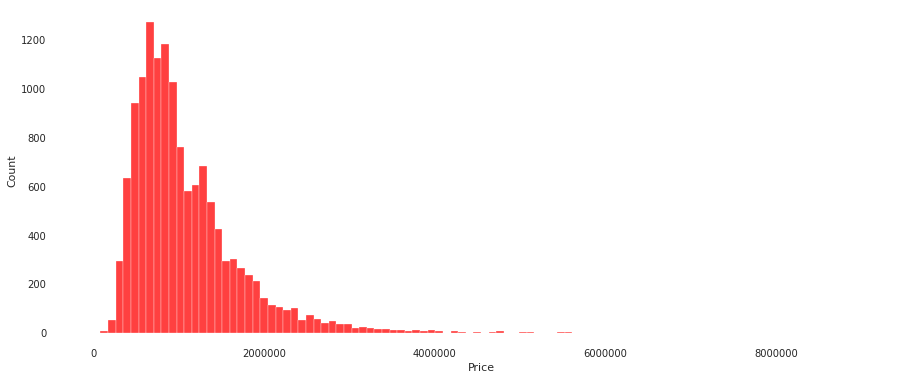

In [13]:
plt.figure(figsize=(15,6))
sns.histplot(New_Kaggle.Price.dropna(), bins=100, color ='red')
plt.ticklabel_format(style='plain')
sns.despine()

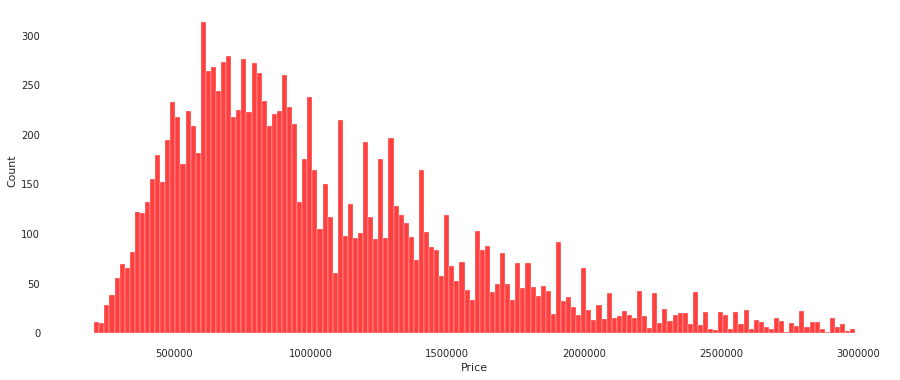

In [14]:
#Filtrado de la base de datos por Precio
New_KaggleP =  New_Kaggle[(New_Kaggle['Price'] > 200000) & (New_Kaggle['Price'] < 3000000)]
plt.figure(figsize=(15,6))
sns.histplot(New_KaggleP['Price'].dropna(), bins=150, color ='red')
plt.ticklabel_format(style='plain')
sns.despine()

In [15]:
#Filtrado de la base de datos por valores extremos Rooms: No es necesario porque el valor extremo quedó fuera en el filtro de precio

#Filtrado de la base de datos por valores extremos Car
New_KaggleC =  New_KaggleP[New_KaggleP['Car'] < 7]

#Filtrado de la base de datos por valores extremos YearBuilt
New_KaggleY =  New_KaggleC[New_KaggleC['YearBuilt'] > 1989]

In [16]:
print(len(kaggle_df))
print(len(New_Kaggle))
print(len(New_KaggleP))
print(len(New_KaggleC))
print(len(New_KaggleY))

13580
13580
13336
13256
2564


La salida anterior muestra la pérdida de datos por cada filtrado, destacando el caso de YearBuilt donde la base de datos se reduce drásticamente. Esto impide el uso de YearBuilt como variable predictora.

2.2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 
  2.2.1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
  

In [ ]:
# Seleccionamos las variables a agregar
interesting_features = ['zipcode','price', 'weekly_price', 'monthly_price']
AirB = pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv', usecols=interesting_features)

In [19]:
# Filtramos las columnas correspondientes a las variables seleccionadas y luego realizamos la agregación agrupando por zipcode.
# La operación conlleva pasar como argumento el nombre de la nueva columna y como valor una tupla donde el primer valor es el nombre de la
# columna original y el segundo valor es la operación de agregación que nos interesa.
AirB_agg = AirB[interesting_features].groupby('zipcode').agg(AirB_record_count=('price', 'count'),
        AirB_daily_price_mean=('price', 'mean'),
        AirB_weekly_price_mean=('weekly_price', 'mean'),
        AirB_monthly_price_mean=('monthly_price', 'mean'))\
        .reset_index()

In [20]:
AirB_agg.head()

,zipcode,AirB_record_count,AirB_daily_price_mean,AirB_weekly_price_mean,AirB_monthly_price_mean
0,2010.0,1,40.00000,NaN,NaN
1,2134.0,1,50.00000,NaN,NaN
2,2582.0,1,104.00000,NaN,NaN
3,3000.0,2491,149.23605,804.0,3469.0
4,3001.0,1,120.00000,NaN,NaN


2.2.2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
 

In [21]:
# Seleccionamos los zipcodes que tienen al menos 3 registros en un compromiso entre contar con suficientes datos sin perder demasiados zipcodes 
AirB_aggClean = AirB_agg[AirB_agg['AirB_record_count']>2]
print(len(AirB_agg))
print(len(AirB_aggClean))

463
396


In [ ]:
# Convertimos zipcode de object a float64 para que coincidan los dtypes al realizar el merge
AirB_aggClean['zipcode'] = AirB_aggClean['zipcode'].astype(float, errors = 'raise')

In [23]:
# Unimos los datasets
Merge_df = New_KaggleC.merge(AirB_aggClean, how='left', left_on='Postcode', right_on='zipcode')
Merge_df.sample(5)

,Price,Rooms,YearBuilt,Car,Postcode,zipcode,AirB_record_count,AirB_daily_price_mean,AirB_weekly_price_mean,AirB_monthly_price_mean
3260,545000.0,2,NaN,1.0,3163.0,3163.0,60.0,91.250000,553.153846,2047.75
4106,1140000.0,2,1960.0,1.0,3108.0,3108.0,18.0,133.000000,1137.500000,5125.25
24427,610000.0,3,NaN,1.0,3020.0,3020.0,32.0,75.968750,NaN,NaN
3962,1430000.0,2,NaN,0.0,3066.0,3066.0,131.0,143.442748,919.270270,3078.72
5957,830000.0,2,NaN,2.0,3188.0,3188.0,40.0,266.500000,NaN,NaN


 2.2.3. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Ambas bases de datos cuentan con columnas que contienen los suburbios y las ciudades (Council Area) comprendidas dentro del área metropolitana de Melbourne. Cabe destacar, que en Australia, un suburbio es una localidad delimitada dentro de una ciudad, por lo que sería algo equivalente a un barrio en Argentina. Los suburbios suelen tener su propio código postal y en ocasiones 2 suburbios comparten código postal. La primera base de datos cuenta con las columnas "Suburb" (314 unique values) y "Council Area" (34 unique values). La segunda base de datos cuenta con las columnas "suburb" (543 unique values) y "city" (30 unique values). En las 4 features practicamente no hay missing values. 
Dadas estas características, ambas variables podrían ser consideradas en reemplazo del zipcode para la combinación de datasets. Los suburbios permitirían obtener un mayor grado de detalle en la caracterización comparado con zipcode y ciudad. Mientras que el uso de ciudad permitiría una mejor estimación de las métricas por contar con una mayor cantidad de valores para su cálculo.

## Ejercicio 3:

3.1.Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

## Ejercicios opcionales:

1. Armar un script en python (archivo .py) [ETL](https://towardsdatascience.com/what-to-log-from-python-etl-pipelines-9e0cfe29950e) que corra los pasos de extraccion, transformacion y carga, armando una funcion para cada etapa del proceso y luego un main que corra todos los pasos requeridos.

2. Armar un DAG en Apache Airflow que corra el ETL. (https://airflow.apache.org/docs/apache-airflow/stable/tutorial.html)